In [23]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, \
GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, \
make_scorer, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as SmPipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from src.functions import load_OU_data, CourseScaler, plot_confusion, pass_f1, make_gridpipe, \
score_grid
import pickle

import warnings

warnings.filterwarnings("ignore")
sns.set_style('white')
pd.set_option('display.max_columns',None)

## Drop the Irrelevant Columns
We are hoping to predict only on data that can be collected by the online learning service, so we need to drop data that those services might not have.  In our EDA, we found that demographic data was not strongly correlated to course outcomes anyway.

## Set Prediction Window to 100

In [2]:
df = load_OU_data(prediction_window=100)
df.drop(columns = ['id_student','code_presentation','region','highest_education', \
                   'imd_band','gender','age_band','disability','studied_credits',
                   'module_presentation_length','date_registration'], inplace = True)
if 'date_unregistration' in df.columns:
    df.drop(columns = ['date_unregistration'], inplace = True)
df.head()

,code_module,num_of_prev_attempts,final_result,days_studied,activities_engaged,total_clicks,assessments_completed,average_assessment_score
0,AAA,0,Pass,24,110,592,2,81.5
1,AAA,0,Pass,42,254,874,2,69.0
2,AAA,0,Pass,57,320,1079,2,71.5
3,AAA,0,Pass,37,201,722,2,49.5
4,AAA,0,Pass,61,320,1135,2,74.0


## Preprocessing

In [3]:
X = df.drop(columns = ['final_result'])
y = df['final_result']
labels = ['Distinction','Pass','Fail','Withdrawn']
print(y.value_counts())

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

cs = CourseScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=111, test_size=0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111, test_size=0.2)


Pass           11776
Fail            5558
Distinction     2818
Withdrawn       2466
Name: final_result, dtype: int64


# Logistic Reg

I'm using `cross_val_predict()` that returns a prediction made up of many different folded versions of the model, so `y[45:90]` might be predictions for for fold 1 and `y[90:135]` might be predictions for fold 2.  It's a Frankenstein prediction!  The average accuracy of the predictions should represent a cross validated accuracy of the model, however, more or less.

cross accuracy score for "Pass" class:
[0.57667864 0.57916552 0.57529704 0.59270517 0.58291874]


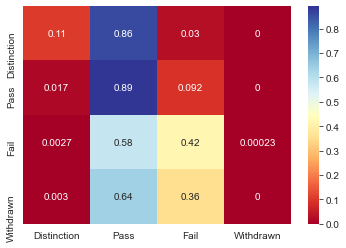

In [4]:
LRpipeline = Pipeline(steps = [('scaler', CourseScaler(drop_course = True)),
                               ('model', LogisticRegression())])

scores = cross_val_score(LRpipeline, X_train, y_train, scoring = 'accuracy' )
y_pred = cross_val_predict(LRpipeline, X_train, y_train, cv=cv)

print('cross accuracy score for "Pass" class:')
print(scores)
plot_confusion(y_train, y_pred, labels)

### Evaluation
Comparing to our FSM (see FSM notebook), we have only lost a little accuracy by setting the prediction window to 100 days and removing demographic data and focusing only on virtual learning environment interaction data and assessment scores.  Our biggest change here is that the model cannot predict withdrawing students with a prediction window of 100.  One interesting result here is that with a prediction window of 50 the model is able to predict a few withdrawals.

Let's explore some class balancing strategies to help our model learn about withdrawing students

# SMOTE
We can't use pipelines with smote, so we will use a validation set instead.  results may not be perfectly comparable to ones above.

In [5]:
smotesteps = [('scaler', CourseScaler()),
             ('smoter',SMOTE(random_state=111)),
             ('logreg', LogisticRegression())]

SMLRpipeline = SmPipeline(smotesteps)

cross validated F1 score for "Pass" class:
[0.42470296 0.423874   0.42497928 0.43713733 0.43504699]


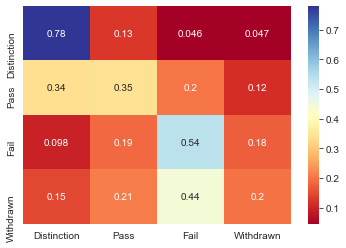

In [6]:
scores = cross_val_score(SMLRpipeline, X_train, y_train, scoring = 'accuracy' )
y_pred = cross_val_predict(SMLRpipeline, X_train, y_train)
print('cross validated F1 score for "Pass" class:')
print(scores)
plot_confusion(y_train, y_pred, labels=labels)

Interesting!  While overall F1 on passing dropped, the accuracy of every class other than pass increased significantly!  These were the results we were hoping for.  

Especially exciting is that most misclassified 'Pass' samples were classified as 'Distinction' and vice versa.  This was also true between 'Fail' and 'Withdrawn'

SMOTING has been a great success.  Let's see if we can build on this.  Since we are hoping to red-flag students for interventions, we actually don't care if they pass or pass with distinction for the purpose of this predictor.  Let's combine those labels and see if that further improves our accuracy.

## FSM with combined labels

#### Combine 'Distinction' and 'Pass'
Our goal is to efficiently flag students in danger of failing or withdrawing.  We want to do so without intervening with too many students on track to pass, because that wastes time and resources.  When we bring our classes down to just 3, pass, fail, and withdraw, then the problem actually becomes separating the passing students from the others.  For this reason we can use the F1 score specifically on the passing students as a metric.  This will minimize both the students erroneously classified as passing (false positives) and the students erroneously classified as failing or withdrawing (false negatives).  

In [7]:
y3_train = np.array(['Pass' if y == 'Distinction' else y for y in y_train])
y3_test = np.array(['Pass' if y == 'Distinction' else y for y in y_test])
y3_t = np.array(['Pass' if y == 'Distinction' else y for y in y_t])
y3_val = np.array(['Pass' if y == 'Distinction' else y for y in y_val])

labels3 = ['Pass','Fail','Withdrawn']

cross validated F1 score for "Pass" class:
[0.49376231 0.50631313 0.50093926 0.46786632 0.51129761]


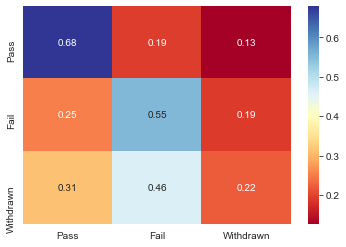

In [8]:


scores = cross_val_score(SMLRpipeline, X_t, y3_t, scoring = make_scorer(pass_f1) )
y_pred = SMLRpipeline.fit(X_t, y3_t).predict(X_val)
print('cross validated F1 score for "Pass" class:')
print(scores)
plot_confusion(y3_val, y_pred, labels=labels3)

### Evaluation:
This is a good start, but we need to improve on it.  Also, these numbers are somewhat inflated because the model trained on the entire training set

cross validated F1 score for "Pass" class:
[0.4395466  0.43413729 0.44231995 0.44129032 0.42885506]


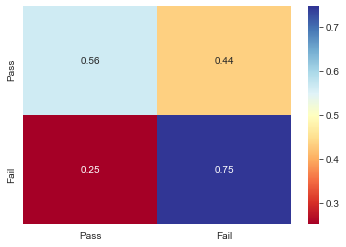

In [9]:
y2_train = np.array(['Fail' if y == 'Withdrawn' else y for y in y_train])
y2_test = np.array(['Fail' if y == 'Withdrawn' else y for y in y_test])
y2_t = np.array(['Fail' if y == 'Withdrawn' else y for y in y_t])
y2_val = np.array(['Fail' if y == 'Withdrawn' else y for y in y_val])

labels2 = ['Pass','Fail']

scores = cross_val_score(SMLRpipeline, X_train, y2_train, scoring = make_scorer(pass_f1) )
y_pred = cross_val_predict(SMLRpipeline, X_train, y2_train)
print('cross validated F1 score for "Pass" class:')
print(scores)
plot_confusion(y2_train, y_pred, labels=labels2)

### Evaluation:
This did not improve on the 3 class version.  We have far too many false positive failing students.  Most students pass.  The majority of student receiving interventions would have passed anyway.  We will go ahead and stick with our 3 classes.

## GridsearchCV for best logistic regression hyperparameters

cross validated F1 score for "Pass" class:
0.49736359272621317


Pipeline(steps=[('scaler', CourseScaler()), ('smoter', SMOTE(random_state=111)),
                ('model',
                 LogisticRegression(random_state=111, solver='liblinear'))])

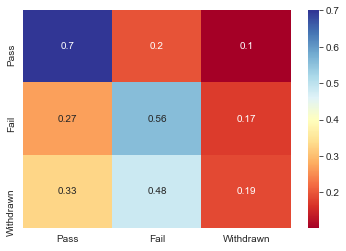

In [10]:
LRparams = [{'model__solver': ['lbfgs','sag','saga','newton-cg'],
         'model__penalty': ['none'],
         'model__random_state':[111]},
          {'model__solver': ['lbfgs','sag','saga','newton-cg','liblinear'],
         'model__penalty': ['l2'],
         'model__random_state':[111]},
          {'model__solver':['saga'],
          'model__penalty':['elasticnet']},
          {'model__solver':['saga','liblinear'],
          'model__penalty':['l1']}]


LRgrid = make_gridpipe(LogisticRegression(),LRparams, cv= cv)

LRmodel = LRgrid.fit(X_t, y3_t).best_estimator_

score_grid(LRgrid, X_val, y3_val, labels = labels3)
pickle.dump(LRmodel,open('../content/LRmodel.pkl','wb'))

### final LR model evaluation.  This model thends to overpredict students to pass, and still misclassifies about 30% of passing students as in danger of failing or withdrawing.

# More model types
We used the logistic regression classifier to tune our features, but now it's time to try some other models.  We will use GridsearchCV to optimize the hyperparameters

## Gaussian Naive Bayes

cross validated F1 score for "Pass" class:
0.4889223231181622
Pipeline(steps=[('scaler', CourseScaler()), ('smoter', SMOTE(random_state=111)),
                ('model', GaussianNB(var_smoothing=1e-08))])


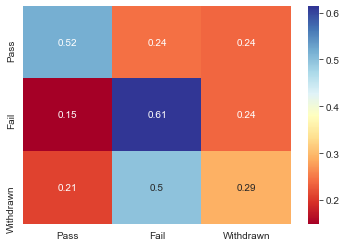

In [13]:

GNBparams = [{'model__var_smoothing':[1e-8,1e-9,1e-10]}]


GNBsmotesteps = [('scaler', CourseScaler()),
             ('smoter',SMOTE(random_state=111)),
             ('GNB', GaussianNB())]

GNBpipeline = SmPipeline(GNBsmotesteps)

GNBgrid = make_gridpipe(GaussianNB(), GNBparams, cv=cv)

GNBgrid.fit(X_t, y3_t)

GNBmodel = score_grid(GNBgrid, X_val, y3_val, labels = labels3)

print(GNBmodel)
pickle.dump(GNBmodel,open('../content/GNBmodel489f1.pkl','wb'))

### Gaussian Naive Bayes Evaluation: 
This model has more false negative predictions for the passing class.  50% of passing students will be tagged as failing or withdrawing.  Whereas other models tended to overpredict passing, this one under predicts it.  The false positive rate, however, is still pretty high as well, though not catastrophic.

cross validated F1 score for "Pass" class:
0.5031116156268767
Pipeline(steps=[('scaler', CourseScaler()), ('smoter', SMOTE(random_state=111)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_features=4, min_samples_split=0.5,
                                        random_state=111))])


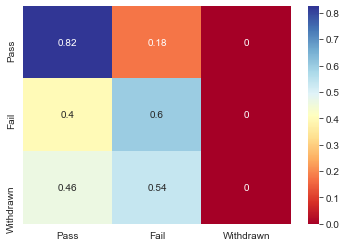

In [14]:
DTparams = {'model__criterion':['gini','entropy'],
           'model__splitter':['best','random'],
           'model__max_depth':[4,10,20],'model__min_samples_split':[.01,.1,.2,.5],
           'model__max_features':[1,2,3,4],'model__random_state':[111]}
           
DTgrid = make_gridpipe(DecisionTreeClassifier(), DTparams, cv=cv)

DTgrid.fit(X_t, y3_t)

DTmodel = score_grid(DTgrid, X_val, y3_val, labels = labels3)
print(DTmodel)
pickle.dump(GNBmodel,open('../content/DTmodel503f1.pkl','wb'))

### Decision Tree Evaluation 
Even with SMOTE-ing this model decided no one would withdraw from the courses, and split the true withdrawals between passes and fails.  It caught 60% of students who would have failed and 82% of students who passes.  The good news about this one is that not too many resources would be wasted needlessly intervening with passing students, as only 18% of passing students were classfified as failing, but the bad news is that it misses 40% of failing students and 46% of withdrawing students.

cross validated F1 score for "Pass" class:
0.51185297635644
Pipeline(steps=[('scaler', CourseScaler()), ('smoter', SMOTE(random_state=111)),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=4,
                                        max_features=3, min_samples_split=0.5,
                                        n_estimators=300, n_jobs=-1,
                                        oob_score=True, random_state=111))])


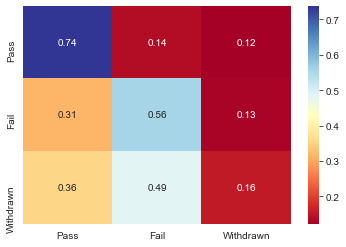

In [28]:
RFparams = {'model__n_estimators':[10,100,300],
           'model__criterion':['gini','entropy'],
           'model__max_depth':[4,7,10],
           'model__min_samples_split':[.2,.5,.7],
           'model__max_features':[2,3,4],
           'model__oob_score':[True,False],
           'model__n_jobs':[-1],'model__random_state':[111],
           'model__max_samples':[.5,.7,None]}
           
RFgrid = make_gridpipe(RandomForestClassifier(), RFparams, cv=cv)

RFgrid.fit(X_t, y3_t)

RFmodel = score_grid(RFgrid, X_val, y3_val, labels = labels3)
print(RFmodel)
pickle.dump(RFmodel, open('../content/RFmodel51f1.pkl','wb'))

### Random Forest Classifier Evaluation:
This is the best model yet for our purposes.  It classifies almost 70% of failing students as needing intervention (either failing or withdrawing) and 65% of students who will withdraw as falling into one of those categories.  It successfully identifies 74% of students who will pass, suggesting unnecessary interventions for only 26% of students who will pass.  The false positive rate for interventions is not as good as the straight decision tree (26% for the Random Forest, 18% for the Decision Tree) but the false negative rate is also quite a bit lower.  